# Classification with Segment Network
* Summary: This was a success. Models train well
* Learning: for MNIST grayscale works well all you need to do is flatten it by row or col and feed it it.

# Initialization

In [12]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import time
from tqdm import tqdm

from segment import Segment

%matplotlib inline


In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    #else "mps"
    #if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
def set_random_seeds(seed_value=42):
    """Sets all possible random seeds so results can be reproduced."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds()

# MNIST dataset

In [15]:
from typing import Any
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())
bw_array_transform = transforms.Lambda(lambda x: torch.where(x < x.mean(), 0., 1.))
position_transform = transforms.Lambda(lambda x: x*torch.arange(1, x.shape[0]+1.)/x.shape[0] )

class subtract_pos_transform():
    """
    NOTE: This transform creates output tensor of size N*(N-1)/2 (N is the length of the input tensor
    This is too large.

    Args:
    tensor (Tensor): Tensor 1D flattened image from position transform.

    Returns:
        Tensor: Tensor with pixel differences from other non zero pixels.
    """
    def __call__(self, tensor) -> Any:
        diff_matrix = tensor.view(tensor.shape[0],1) - tensor
        results = []
        for i in range(diff_matrix.size(0)):
            results.append(diff_matrix[i, i+1:])

        return torch.cat(results).flatten()

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.RandomRotation(15),
    #bw_array_transform,
    flatten_by_row_transform
    #position_transform
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #bw_array_transform,
    flatten_by_row_transform
    #position_transform     
])

train_set = datasets.MNIST('../../data', train=True, download=False, transform=train_transform)
test_set = datasets.MNIST('../../data', train=False, download=False, transform=test_transform)
print(len(train_set), len(test_set))
print(train_set[0][0].shape, test_set[0][0].shape)

60000 10000
torch.Size([784]) torch.Size([784])


# Model Definition
* Start with single layer Segment with output = number of labels
* Then increase number of layers to see if loss reduces 
* Then try transposing input x and batch size and see if it trains better

# Model Training

In [16]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size, segment_size):
        super().__init__()
        self.seg1 = Segment(input_size, output_size, segment_size)
        self.init = False

    def forward(self, x):
        if self.training and not self.init:
            self.seg1.custom_init(torch.zeros_like(x.min(dim=0).values), torch.ones_like(x.max(dim=0).values))
            self.init = True
        x = self.seg1(x)
        return x

In [17]:
#Permute input to seg1.
#Seg2 input should be the parameters from seg1 (not output)
class MyModel(nn.Module):
    def __init__(self, input_size, batch_size, segment1_size, segment2_size, segment3_size, output_dim):
        super().__init__()
        self.init = False
        self.seg1 = Segment(1, batch_size, segment1_size)
        seg2_output_size = segment1_size+1
        self.x_in = None
        #split seg2 into x,y parts to reduce unnecessary parameters
        self.seg2x = Segment(input_size, seg2_output_size, segment2_size)
        self.seg2y = Segment(input_size, seg2_output_size, segment2_size)
        self.seg3 = Segment(2*seg2_output_size, output_dim, segment3_size)
        
    def custom_init(self, x):
        x_min = torch.zeros(self.seg1.in_features, dtype=x.dtype)
        x_max = torch.ones(self.seg1.in_features, dtype=x.dtype)
        self.seg1.custom_init(x_min, x_max)
        x_min = torch.zeros(self.seg2x.in_features, dtype=x.dtype)
        x_max = torch.ones(self.seg2x.in_features, dtype=x.dtype)
        self.seg2x.custom_init(x_min, x_max)
        self.seg2y.custom_init(x_min, x_max)
        x_min = torch.zeros(self.seg3.in_features, dtype=x.dtype)
        x_max = torch.ones(self.seg3.in_features, dtype=x.dtype)
        self.seg3.custom_init(x_min, x_max)
        
        self.init = True

    def forward(self, x):
        if self.training:
            if not self.init:
                self.custom_init(x)
            
            #Train a model1 that predicts x,y for the input x_in so output is x
            self.x_in = torch.arange(1, x.shape[1]+1.)/x.shape[1]
            self.x_in.unsqueeze_(-1)
            y1 = self.seg1(self.x_in)
            loss1 = F.mse_loss(y1, x.permute(1,0))

        
        self.xembeddings = self.seg2x(x)
        self.yembeddings = self.seg2y(x)
        
        if self.training:
            seg1_xparams = self.seg1.x.view(self.seg1.x.shape[2], self.seg1.x.shape[1])
            seg1_yparams = self.seg1.y.view(self.seg1.y.shape[2], self.seg1.y.shape[1])
            loss2x = F.mse_loss(self.xembeddings, seg1_xparams)
            loss2y = F.mse_loss(self.yembeddings, seg1_yparams)
        
        self.embeddings = torch.cat((self.xembeddings, self.yembeddings), dim=1)
        ypred = self.seg3(self.embeddings)

        if self.training:
            return [loss1, loss2x, loss2y], ypred
        else:
            return ypred
    

In [18]:
# Define Model : 1 input, 1 output, play with segments starting from 1/2 of image pixels.
BATCH_SIZE=64
set_random_seeds()

#model = SimpleModel(784,10,10)
model = MyModel(784, 64, 14, 3, 10, 10).to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
total_params = sum(p.numel() for p in model.seg1.parameters())
print(f"Seg1 parameters: {total_params}")
total_params = sum(p.numel() for p in model.seg2x.parameters())
print(f"Seg2(x,y) parameters: {total_params}, {total_params}")
total_params = sum(p.numel() for p in model.seg3.parameters())
print(f"Seg3 parameters: {total_params}")
print(f"Device = {next(model.parameters()).device}")

MyModel(
  (seg1): Segment(in_features=1, out_features=64, segment_features=14)
  (seg2x): Segment(in_features=784, out_features=15, segment_features=3)
  (seg2y): Segment(in_features=784, out_features=15, segment_features=3)
  (seg3): Segment(in_features=30, out_features=10, segment_features=10)
)
Total parameters: 196680
Seg1 parameters: 1920
Seg2(x,y) parameters: 94080, 94080
Seg3 parameters: 6600
Device = cpu


In [19]:
criterion = nn.CrossEntropyLoss()

lr=1e-4
#optimizer only optimizes parameter that are sent to it in arg1
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=lr, betas=(0.9, 0.999), eps=1e-8)
num_epochs = 30

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

start = time.time()
training_losses = np.empty((0, 4))
val_losses = np.empty((0))
val_accuracies = np.empty((0))
for epoch in range(1,num_epochs+1):
    model.train()
    t0 = time.time()
    step = 0
    epoc_losses = np.zeros((4))
    for data in tqdm(train_dataloader, position=0, leave=True):
        img, label = data
        img = img.to(device)
        label = label.to(device)

        #don't train for wrong batch size for now
        if img.shape[0] != BATCH_SIZE:
            continue

        # ===================forward=====================
        losses, y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        class_loss = criterion(y_pred, label)
        losses.append(class_loss)
        if(math.isnan(class_loss)):
            print(f"nan class_loss at step {step}")
            break
        # ===================backward====================
        # Try not training 1st three segments after 1st EPOCH
        if epoch> 100:
            for param in model.seg1.parameters():
                param.requires_grad = False
            for param in model.seg2x.parameters():
                param.requires_grad = False
            for param in model.seg2y.parameters():
                param.requires_grad = False
                
        optimizer.zero_grad()
        loss = losses[0] + losses[1] + losses[2] + losses[3]
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for i in range(len(losses)):
                epoc_losses[i] += losses[i].item()

        step += 1
    # ===================log========================
    t1 = time.time()
    training_losses = np.append(training_losses, [epoc_losses/len(train_dataloader)], axis=0)
    
    if(math.isnan(class_loss)):
        print("nan class_loss ")
        break

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for data in tqdm(test_dataloader, position=0, leave=True):
            img, label = data
            img = img.to(device)
            label = label.to(device)
            #don't test for wrong batch size for now
            #if img.shape[0] != BATCH_SIZE:
            #    continue
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss/len(test_dataloader)
    val_losses = np.append(val_losses, val_loss)
    val_accuracy = sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    val_accuracies = np.append(val_accuracies, val_accuracy)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch}: {epoc_losses/len(train_dataloader)}")
    print(f"Valid Loss EPOCH {epoch}: {val_loss:.4f}")
    #print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch}: {val_accuracy:.4f}")
    print("-"*30)

stop = time.time()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 157/157 [00:01<00:00, 80.90it/s]


------------------------------
Train Loss EPOCH 1: [0.10588961 0.104936   0.07414109 1.38315306]
Valid Loss EPOCH 1: 0.6679
Valid Accuracy EPOCH 1: 0.8859
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.19it/s]


------------------------------
Train Loss EPOCH 2: [0.09985123 0.1097333  0.11161126 0.51659742]
Valid Loss EPOCH 2: 0.3621
Valid Accuracy EPOCH 2: 0.9168
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.73it/s]


------------------------------
Train Loss EPOCH 3: [0.09740336 0.11259818 0.09990805 0.36090231]
Valid Loss EPOCH 3: 0.2705
Valid Accuracy EPOCH 3: 0.9323
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.71it/s]


------------------------------
Train Loss EPOCH 4: [0.09600285 0.11399607 0.09064365 0.30363221]
Valid Loss EPOCH 4: 0.2328
Valid Accuracy EPOCH 4: 0.9396
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.68it/s]


------------------------------
Train Loss EPOCH 5: [0.09506221 0.11445249 0.08422749 0.26992099]
Valid Loss EPOCH 5: 0.2213
Valid Accuracy EPOCH 5: 0.9431
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.94it/s]


------------------------------
Train Loss EPOCH 6: [0.09432425 0.11510241 0.07876616 0.24693209]
Valid Loss EPOCH 6: 0.2064
Valid Accuracy EPOCH 6: 0.9436
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.53it/s]


------------------------------
Train Loss EPOCH 7: [0.0937513  0.11564205 0.07517681 0.23013876]
Valid Loss EPOCH 7: 0.1912
Valid Accuracy EPOCH 7: 0.9494
------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.88it/s]


------------------------------
Train Loss EPOCH 8: [0.09333033 0.11590323 0.07188517 0.2146734 ]
Valid Loss EPOCH 8: 0.1850
Valid Accuracy EPOCH 8: 0.9498
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.41it/s]


------------------------------
Train Loss EPOCH 9: [0.09295948 0.11620357 0.06916575 0.20670836]
Valid Loss EPOCH 9: 0.1748
Valid Accuracy EPOCH 9: 0.9502
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.05it/s]


------------------------------
Train Loss EPOCH 10: [0.09263948 0.11652124 0.06741392 0.19738273]
Valid Loss EPOCH 10: 0.1709
Valid Accuracy EPOCH 10: 0.9492
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.42it/s]


------------------------------
Train Loss EPOCH 11: [0.09234375 0.11653747 0.06585839 0.18915121]
Valid Loss EPOCH 11: 0.1575
Valid Accuracy EPOCH 11: 0.9558
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.92it/s]


------------------------------
Train Loss EPOCH 12: [0.09215292 0.11698317 0.06382269 0.18395732]
Valid Loss EPOCH 12: 0.1819
Valid Accuracy EPOCH 12: 0.9488
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.23it/s]


------------------------------
Train Loss EPOCH 13: [0.09198647 0.11792171 0.06326036 0.17960712]
Valid Loss EPOCH 13: 0.1760
Valid Accuracy EPOCH 13: 0.9469
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.14it/s]


------------------------------
Train Loss EPOCH 14: [0.09184237 0.11786713 0.0617698  0.17157013]
Valid Loss EPOCH 14: 0.1460
Valid Accuracy EPOCH 14: 0.9592
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.83it/s]


------------------------------
Train Loss EPOCH 15: [0.09175662 0.11778859 0.0602682  0.16754271]
Valid Loss EPOCH 15: 0.1671
Valid Accuracy EPOCH 15: 0.9505
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.90it/s]


------------------------------
Train Loss EPOCH 16: [0.09162297 0.11856223 0.05983373 0.16525793]
Valid Loss EPOCH 16: 0.1632
Valid Accuracy EPOCH 16: 0.9524
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.65it/s]


------------------------------
Train Loss EPOCH 17: [0.09151927 0.11865163 0.0591275  0.16394547]
Valid Loss EPOCH 17: 0.1473
Valid Accuracy EPOCH 17: 0.9585
------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.59it/s]


------------------------------
Train Loss EPOCH 18: [0.0914536  0.11895862 0.05858306 0.16027091]
Valid Loss EPOCH 18: 0.1543
Valid Accuracy EPOCH 18: 0.9526
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.75it/s]


------------------------------
Train Loss EPOCH 19: [0.09135971 0.1189092  0.05732679 0.15557309]
Valid Loss EPOCH 19: 0.1432
Valid Accuracy EPOCH 19: 0.9573
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.25it/s]


------------------------------
Train Loss EPOCH 20: [0.09131693 0.11877774 0.05749916 0.15634487]
Valid Loss EPOCH 20: 0.1360
Valid Accuracy EPOCH 20: 0.9609
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.45it/s]


------------------------------
Train Loss EPOCH 21: [0.09127437 0.11877875 0.05600272 0.14827522]
Valid Loss EPOCH 21: 0.1546
Valid Accuracy EPOCH 21: 0.9527
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.31it/s]


------------------------------
Train Loss EPOCH 22: [0.09119095 0.11897916 0.05596464 0.15123342]
Valid Loss EPOCH 22: 0.1279
Valid Accuracy EPOCH 22: 0.9619
------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.84it/s]


------------------------------
Train Loss EPOCH 23: [0.09113155 0.11935548 0.05573419 0.14802521]
Valid Loss EPOCH 23: 0.1509
Valid Accuracy EPOCH 23: 0.9551
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.92it/s]


------------------------------
Train Loss EPOCH 24: [0.09110413 0.11927047 0.05533654 0.14466985]
Valid Loss EPOCH 24: 0.1464
Valid Accuracy EPOCH 24: 0.9554
------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.42it/s]


------------------------------
Train Loss EPOCH 25: [0.0910707  0.1197537  0.05441773 0.14448034]
Valid Loss EPOCH 25: 0.1261
Valid Accuracy EPOCH 25: 0.9644
------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.70it/s]


------------------------------
Train Loss EPOCH 26: [0.09100575 0.12004139 0.05418686 0.14046849]
Valid Loss EPOCH 26: 0.1651
Valid Accuracy EPOCH 26: 0.9485
------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.57it/s]


------------------------------
Train Loss EPOCH 27: [0.09093269 0.11977326 0.05439401 0.14522422]
Valid Loss EPOCH 27: 0.1369
Valid Accuracy EPOCH 27: 0.9601
------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.05it/s]


------------------------------
Train Loss EPOCH 28: [0.09091253 0.11995435 0.0532619  0.13700681]
Valid Loss EPOCH 28: 0.1183
Valid Accuracy EPOCH 28: 0.9650
------------------------------


100%|██████████| 157/157 [00:01<00:00, 86.66it/s]


------------------------------
Train Loss EPOCH 29: [0.09091921 0.12047201 0.05330665 0.13608537]
Valid Loss EPOCH 29: 0.1402
Valid Accuracy EPOCH 29: 0.9565
------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.90it/s]


------------------------------
Train Loss EPOCH 30: [0.0908953  0.120412   0.05278362 0.13787572]
Valid Loss EPOCH 30: 0.1383
Valid Accuracy EPOCH 30: 0.9543
------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.99it/s]


------------------------------
Train Loss EPOCH 31: [0.0908747  0.12064576 0.05266837 0.13155158]
Valid Loss EPOCH 31: 0.1181
Valid Accuracy EPOCH 31: 0.9640
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.50it/s]


------------------------------
Train Loss EPOCH 32: [0.09084328 0.12054472 0.05336462 0.13558526]
Valid Loss EPOCH 32: 0.1456
Valid Accuracy EPOCH 32: 0.9540
------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.88it/s]


------------------------------
Train Loss EPOCH 33: [0.09082369 0.12011809 0.05234407 0.13112837]
Valid Loss EPOCH 33: 0.1310
Valid Accuracy EPOCH 33: 0.9609
------------------------------


100%|██████████| 157/157 [00:01<00:00, 86.04it/s]


------------------------------
Train Loss EPOCH 34: [0.09079159 0.12051994 0.05169044 0.1326421 ]
Valid Loss EPOCH 34: 0.1309
Valid Accuracy EPOCH 34: 0.9594
------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.62it/s]


------------------------------
Train Loss EPOCH 35: [0.09074249 0.12042428 0.05194616 0.13010457]
Valid Loss EPOCH 35: 0.1272
Valid Accuracy EPOCH 35: 0.9639
------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.67it/s]


------------------------------
Train Loss EPOCH 36: [0.09071412 0.12015277 0.05177138 0.12926518]
Valid Loss EPOCH 36: 0.1237
Valid Accuracy EPOCH 36: 0.9607
------------------------------


100%|██████████| 157/157 [00:02<00:00, 77.29it/s]


------------------------------
Train Loss EPOCH 37: [0.09069472 0.12022835 0.05202212 0.13066322]
Valid Loss EPOCH 37: 0.1216
Valid Accuracy EPOCH 37: 0.9640
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.45it/s]


------------------------------
Train Loss EPOCH 38: [0.09069372 0.12076284 0.05162498 0.12602639]
Valid Loss EPOCH 38: 0.1252
Valid Accuracy EPOCH 38: 0.9606
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.19it/s]


------------------------------
Train Loss EPOCH 39: [0.09066246 0.12060937 0.05073947 0.12770858]
Valid Loss EPOCH 39: 0.1342
Valid Accuracy EPOCH 39: 0.9598
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.71it/s]


------------------------------
Train Loss EPOCH 40: [0.09066175 0.12097428 0.0512603  0.12762498]
Valid Loss EPOCH 40: 0.1455
Valid Accuracy EPOCH 40: 0.9544
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.34it/s]


------------------------------
Train Loss EPOCH 41: [0.09066681 0.12109634 0.05124642 0.12626619]
Valid Loss EPOCH 41: 0.1389
Valid Accuracy EPOCH 41: 0.9567
------------------------------


100%|██████████| 157/157 [00:02<00:00, 77.67it/s]


------------------------------
Train Loss EPOCH 42: [0.09065825 0.12142357 0.05044226 0.12641974]
Valid Loss EPOCH 42: 0.1205
Valid Accuracy EPOCH 42: 0.9619
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.18it/s]


------------------------------
Train Loss EPOCH 43: [0.09059635 0.12230104 0.05104452 0.12967252]
Valid Loss EPOCH 43: 0.1646
Valid Accuracy EPOCH 43: 0.9500
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.40it/s]


------------------------------
Train Loss EPOCH 44: [0.09057508 0.12135194 0.05105221 0.12496576]
Valid Loss EPOCH 44: 0.1182
Valid Accuracy EPOCH 44: 0.9633
------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.29it/s]


------------------------------
Train Loss EPOCH 45: [0.09056806 0.12129782 0.05033035 0.12101317]
Valid Loss EPOCH 45: 0.1154
Valid Accuracy EPOCH 45: 0.9643
------------------------------


100%|██████████| 157/157 [00:01<00:00, 79.21it/s]


------------------------------
Train Loss EPOCH 46: [0.09054613 0.12174149 0.05035481 0.12235459]
Valid Loss EPOCH 46: 0.1169
Valid Accuracy EPOCH 46: 0.9633
------------------------------


100%|██████████| 157/157 [00:01<00:00, 78.86it/s]


------------------------------
Train Loss EPOCH 47: [0.09053119 0.12145293 0.05038767 0.12633843]
Valid Loss EPOCH 47: 0.1228
Valid Accuracy EPOCH 47: 0.9623
------------------------------


 43%|████▎     | 402/938 [00:12<00:16, 32.77it/s]


KeyboardInterrupt: 

### CPU backend
* Training 35.35it/s
* Test 82.04it/s

### MPS backend
* Training 27.82it/s
* Test 122.02it/s

# Plot Losses

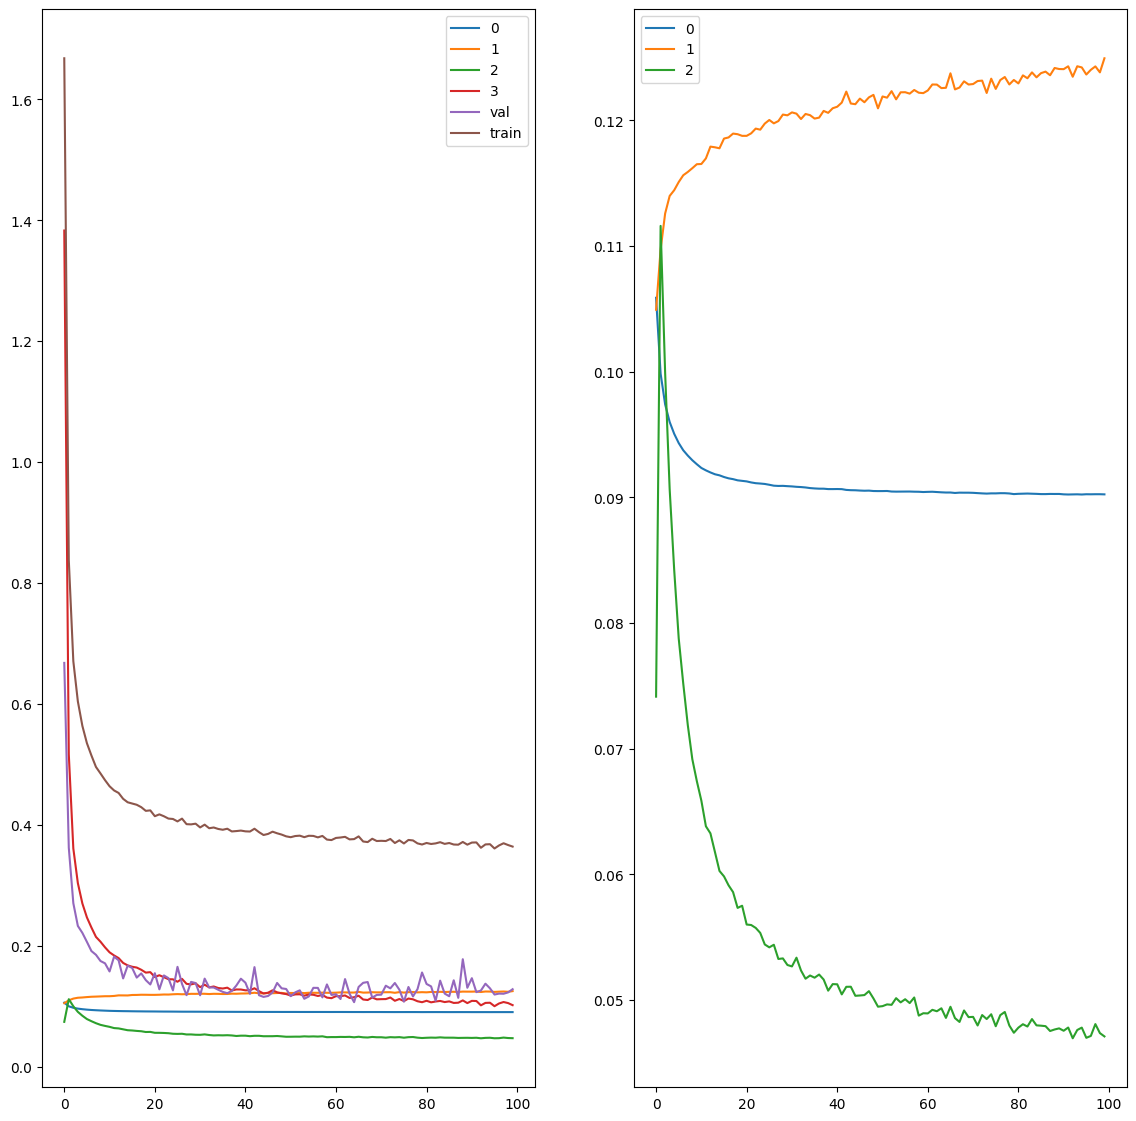

In [ ]:
# Plot all losses
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(121)

x = np.arange(0, len(training_losses[:,0]+1))
for i in range(4):
    ax1.plot(x,training_losses[:,i], label=str(i))

ax1.plot(x,val_losses, label='val')
ax1.plot(x,np.sum(training_losses,axis=1), label='train')
ax1.legend()

ax2 = fig.add_subplot(122)
for i in range(3):
    ax2.plot(x,training_losses[:,i], label=str(i))

ax2.legend()
plt.show()

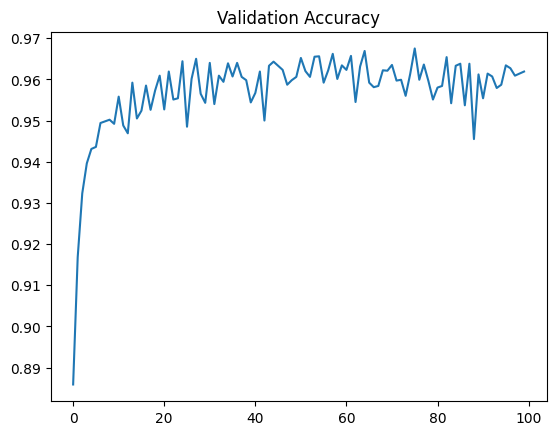

In [ ]:
# Plot only 1st Validation Accuracy
x = np.arange(0, len(training_losses[:,0]+1))
plt.plot(x,val_accuracies)
plt.title('Validation Accuracy')
plt.show()

In [ ]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
#graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
#graph.render("model_Classification_Segment_v2_graph")

In [ ]:
# Max accuracy
val_accuracies.max(), val_losses.min(), val_accuracies[:50].mean()

(0.9675, 0.10666091244216937, 0.9535859999999999)

# Experiment Observations
* model=SimpleModel(784,10,8), model_params=141120, batch_size=64, lr=1e-5, epochs=40, test_acc=0.9118
* model=SimpleModel(784,10,10), model_params=172480, batch_size=64, lr=1e-4, epochs=40, test_acc=0.9239

### Turned off bw_transform and position transform. feeding flatten grayscape to above model
* model=SimpleModel(784,10,10), model_params=172480, batch_size=64, lr=1e-4, epochs=40, test_acc=0.9310 (max 0.935)
* so we are not really learning from shape

### Trained a new model that uses multiple segment nets and tries to predict x,y
*  MyModel(784, 64, 14, 10, 10), model_params=384840, batch_size=64, lr=1e-4, epochs=20, test_acc=0.9231 (max 0.9355)

### Turned ON bw_transform (no position transform)
*  MyModel(784, 64, 14, 10, 10), model_params=384840, batch_size=64, lr=1e-4, epochs=40, test_acc=0.9546 (max 0.9572)
### Turned ON bw_transform, rotation_15 (no position transform) - ramps up faster
*  MyModel(784, 64, 14, 10, 10), model_params=384840, batch_size=64, lr=1e-4, epochs=26, test_acc=0.9585 (max 0.9585)

### Split seg2 in x,y to reduce params by 2x
*  MyModel(784, 64, 14, 10, 10), model_params=196680, batch_size=64, lr=1e-4, epochs=26, test_acc=0.9598 (max 0.9633)

### Experiment with change seg2 models to get transposed input failed spectacularly. Trained to 22% accuracy and slow

### Changed seg2 segments (doubled them) - not much help
*  MyModel(784, 64, 14, 10, 10), model_params=384840, batch_size=64, lr=1e-4, epochs=40, test_acc=0.9634 (max 0.9634)

### Training Observations:
* it appears that seg1, seg2x, seg2y are trained in 1st EPOCH and don't improve later
* this could be good as subsequent training can oly happen to top classifier or other layers
* val accuracies after stopping traning on 1st three segments after 1 epoc
* [0.8088, 0.8473, 0.8555, 0.8602, 0.8629, 0.8666, 0.8687, 0.8711, 0.8726, 0.8736]
* val accuracies if we dont' stop training of 1st three layers is far better
* [0.7624, 0.8795, 0.9052, 0.9236, 0.9255, 0.9326, 0.9397, 0.9404, 0.9348, 0.9463]
* Conclusion: Though the 1st three layers reduce loss less they have a huge impact.

### Turned on position_transform on bw_transform (all above runs). but didn't make a huge dent
* [0.793 , 0.8743, 0.9121, 0.9189, 0.9215, 0.9347, 0.9327, 0.9374, 0.9447, 0.9468]
* MyModel(784, 64, 14, 4, 8, 10) model_params=242520, batch_size=64, lr=1e-4, epochs=10, test_acc=0.9468 (max 0.9468)

### Graycsale (no bw_ tansform, no_position), + 15_rotation looks great (no value of BW or position)
* [0.8642, 0.9172, 0.9292, 0.9375, 0.9383, 0.9391, 0.9471, 0.9509, 0.9489, 0.9487]
*  MyModel(784, 64, 14, 3, 10, 10) model_params=196680, batch_size=64, lr=1e-4, epochs=40, test_acc=0.9544 (max 0.96.50)

# END